# **匯入函式庫**

In [57]:
#Libraries we need to import
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import os
import random
import warnings
import cv2
warnings.filterwarnings('ignore')

from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Activation
from keras.layers import MaxPooling2D, BatchNormalization

# **前處理**

In [58]:
# Set image_size and batch_size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Target Directory
directory = "../input/flowers-recognition/flowers"

# Train Data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
             directory,
             subset='training',
             validation_split=0.2,
             image_size=IMAGE_SIZE,
             batch_size=BATCH_SIZE,
             seed=42)

# Valid data
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            subset='validation',
            validation_split=0.2,
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
             seed=42)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [59]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

data = get_data("/kaggle/input/flowers-recognition/flowers")

class_names = train_data.class_names
class_names

label_encode = LabelEncoder()
class_names_label_encode = label_encode.fit_transform(class_names)
class_names_label_encode

array([0, 1, 2, 3, 4])

In [60]:
def preprocess_image(image, label, image_shape=224):
    
    img = tf.image.resize(image, [image_shape, image_shape])
    img = img/225.
    
    return tf.cast(img, tf.float32), label

In [61]:
# map the preprocess_image to train_data
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle the data
train_data = train_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# map the preprocess_image to valid_data
valid_data = valid_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle the data
valid_data = valid_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data, valid_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>)

# **建立CNN**

In [62]:
# Set random seed
tf.random.set_seed(42)

# model 1
model_1 = Sequential([
    Conv2D(filters=32, kernel_size=4, padding='same', activation='relu',input_shape=(224,224,3)),
    MaxPool2D(2,2),
    Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'),
    MaxPool2D(2,2), 
    Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(len(class_names_label_encode), activation='softmax')
])

# Compile
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

In [63]:
dire='/kaggle/input/flowers-recognition/flowers'

categories=['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
features=[]
for i in categories:
    path=os.path.join(dire,i)
    num_classes=categories.index(i)
    for img in os.listdir(path):
        if img.endswith('.jpg'):
            
            img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            img_array=cv2.resize(img_array,(150,150))
            features.append([img_array,num_classes])

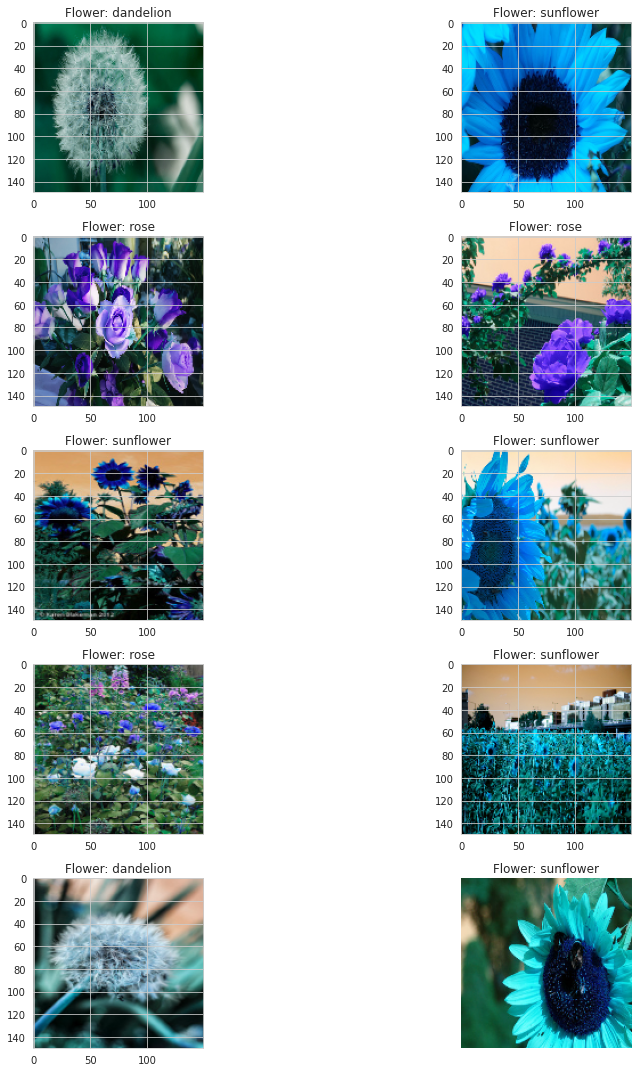

In [64]:
X=[]
y=[]
for i,j in features:
    X.append(i)
    y.append(j)

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+categories[y[l]])
plt.axis('off')        
plt.tight_layout()

In [65]:
X=np.array(X).reshape(-1,150,150,3)/255.0

In [66]:
list_dandelion=len([i for i in y if i==0])
list_daisy=len([i for i in y if i==1])
list_sunflower=len([i for i in y if i==2])
list_tulip=len([ i for i in y if i==3])
list_rose=len([i for i in y if i==4])

In [67]:
list_species=[list_dandelion,list_daisy,list_sunflower,list_tulip,list_rose]

In [68]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(y)

In [69]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=12)

In [70]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2, padding="same"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

In [71]:
epochs=30

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [72]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [73]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_3 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)       

# **訓練模型**

In [75]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 128)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/30
26/26 [==============================] - 70s 3s/step - loss: 1.8115 - accuracy: 0.2764 - val_loss: 1.4522 - val_accuracy: 0.3403
Epoch 2/30
26/26 [==============================] - 67s 3s/step - loss: 1.3675 - accuracy: 0.3979 - val_loss: 1.2430 - val_accuracy: 0.5012
Epoch 3/30
26/26 [==============================] - 67s 3s/step - loss: 1.2289 - accuracy: 0.4657 - val_loss: 1.1325 - val_accuracy: 0.5301
Epoch 4/30
26/26 [==============================] - 64s 2s/step - loss: 1.1752 - accuracy: 0.5023 - val_loss: 1.1227 - val_accuracy: 0.5440
Epoch 5/30
26/26 [==============================] - 68s 3s/step - loss: 1.1364 - accuracy: 0.5323 - val_loss: 1.0822 - val_accuracy: 0.5822
Epoch 6/30
26/26 [==============================] - 67s 3s/step - loss: 1.0688 - accuracy: 0.5823 - val_loss: 1.1023 - val_accuracy: 0.5475
Epoch 7/30
26/26 [==============================] - 66s 3s/step - loss: 1.0426 - accuracy: 0.5919 - val_loss: 0.9597 - val_accuracy: 0.6308
Epoch 8/30
26/26 [==

# **結果**

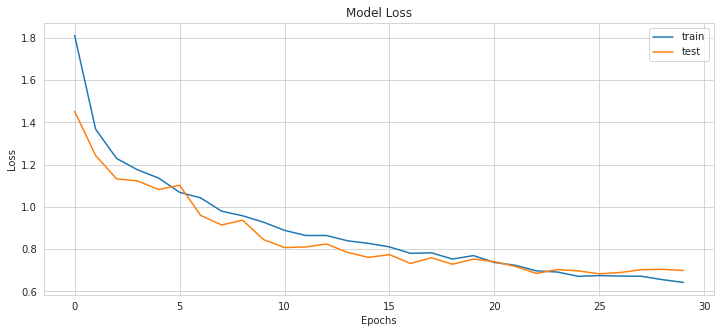

In [76]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

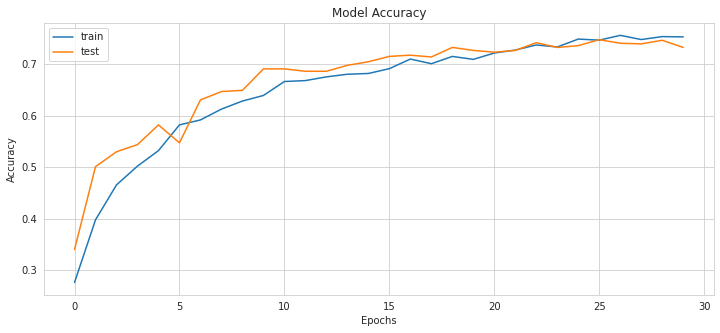

In [77]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# **預測**

In [78]:
preds=model.predict(x_test)

predictions=np.argmax(preds,axis=1)

In [79]:
all_class=[]

i=0
for i in range(len(y_test)):
    all_class.append(i)
    if(len(all_class)==10):
        break

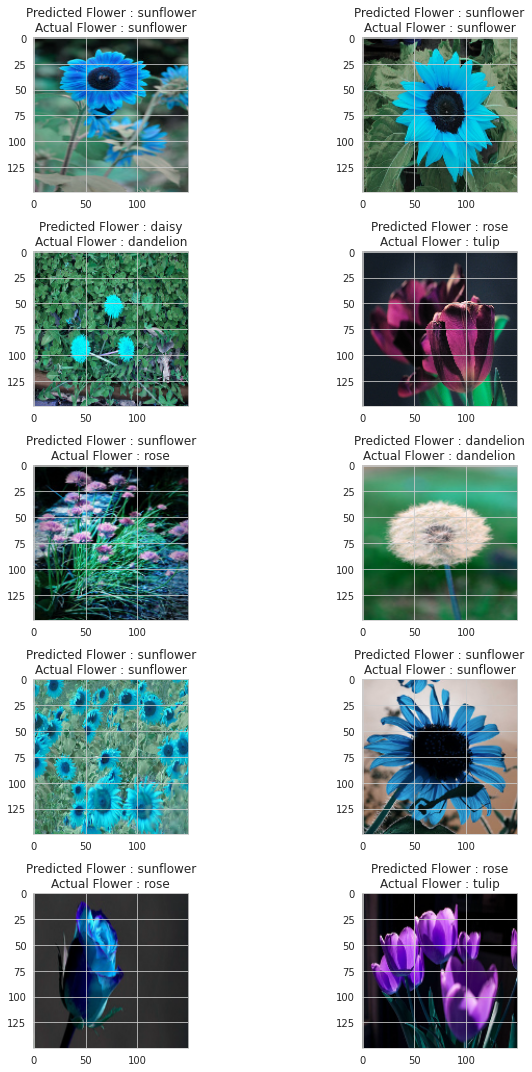

In [80]:
count=0
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (2):
        ax[i,j].imshow(x_test[all_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ categories[predictions[all_class[count]]] +"\n"+"Actual Flower : "+ categories[np.argmax(y_test[all_class[count]])])
        plt.tight_layout()
        count+=1